In [1]:
import pandas as pd 
import numpy as np
import warnings
from random import seed
from sklearn.preprocessing import (MinMaxScaler,
                                   StandardScaler,
                                   OneHotEncoder)
from sklearn.linear_model import (LogisticRegression)
from sklearn.compose import make_column_transformer
from sklearn.model_selection import (train_test_split, 
                                     GridSearchCV)
import json
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from IPython.display import display
from keras.wrappers.scikit_learn import KerasClassifier
from config.config import  (HORSES_DATA_PROCESSED_PATH,
                            FEATURES_TO_SCALE,
                            TRAIN_MODELS,
                            TRAIN_LABELS_PATH,
                            TRAIN_FEATURES_PATH,
                            TRAIN_FEATURES_SCALED_PATH,
                            TEST_SIZE,
                            TEST_LABELS_PATH,
                            TEST_FEATURES_PATH,
                            TEST_FEATURES_SCALED_PATH,
                            MODEL_LABEL,
                            MODEL_FEATURES,
                            PROCESS_DATA,
                            SCALER_PIPELINE_PATH,
                            RANDOM_STATE,
                            LOG_MODEL_PARAMS,
                            DECISION_TREE_PARAMS,
                            RANDOM_FOREST_PARAMS,
                            SVC_MODEL_PARAMS,
                            NN_MODEL_PARAMS)

from lib.lib import (pickle_object,
                     unpickle_object,
                     run_grid_search_with_cv,
                     eval_model,
                     today_string,
                     get_neural_network,
                     plot_discrete_histogram,
                     calc_model_metrics)

warnings.simplefilter(action='ignore',
                      category=FutureWarning)

In [2]:
### Notebook Config
pd.options.display.max_columns = None
seed(1)

#### README: Note on Saved Models
* I have constructed this notebook to load previously generated and saved training/test sets and models.
* This is because rerunning them takes my laptop about 4 hours to finish running all models.
* This is controlled by the PROCESS_DATA and TRAIN_MODELS params, set to False by default (load saved).
* Set both params to false in the config.py file to recreate all datasets and models.

## Modelling

### Modelling Problem: Can we develop a model to beat the bookmakers?
* my modelling will aim to predict winners better than implied by the bookmaker odds.
* The baseline model will use the same test set as the best alternative model for ease of comparison.
* The baseline model will be a £1 bet placed on the horse with the highest odds in each race (favourite)
* The total winnings and winnings per £1 (ROI) will be calculated for this approach.
* I have defined 'beating' the bookmaker as generating a better ROI than implied by the bookmaker's odds.

#### Choosing an alternative model
* I have explored a suite of models that use the bookmaker odds and other features.
    * logistic reg
    * decision tree
    * random forest
    * svc
    * neural network (shallow due to processing limitations).
* The output will be a probability of a horse winning a given race.
* I have chosen the best model from this suite based on recall and f1-score (see below).
* I have evaluated the best model on the test set in the same manner as the baseline model.
    * £1 will be placed on the horse with the highest predicted probability of winning.
    * The total winnings across races will be calculated with the winnings per £1.

##### Model Selection: What metric shall we use to compare alternative models?
* Common Metric choices
    * Precision: TP/(TP+FP)
    * Recall: TP/(TP+FN)
    * Accuracy: (TP+TN)/N
    * F-score: 2* (P*R)/(P+R)
* A good question to ask:
    * "what is the impact of a false positive (Horse will win) vs a false negative (This Horse will lose)"?
* If the model tells me Horse X will win, and it doesn't (TYPE 1 Error), I lose my stake.
    * The evaluation process will always assume £1 is staked (winnings per £1 invested)
* If the model tells me Horse X will lose, and it wins, I've lost the potential winnings.
    * The average StartingPriceProfit ratio is £20.8 (20x stake).
* I should be more concerned about missing winners than betting on losers!
* Therefore, recall will be an essential metric in model selection as it punishes the model for generating false negatives.

##### What metric should be used during the model optimisation process?
* Current Sklearn guidance recommends optimising binary classification models using F1-score
    * Avoids a situation where the model produces only positive labels
    * Has been shown consistently to improve the ability of a model to generalise to unseen data.
    * evidence of better overall performance.
* F1-score contains model recall as a parameter it satisfies the need to avoid missed opportunities.
* F1-score can also be used to evaluate the benefits of additional recall at the cost of precision.

* Therefore, my model optimisation will use F1-score, and my model selection utilises recall and f1-score.

In [3]:
### Load data from analysis
horses_processed = pd.read_csv(HORSES_DATA_PROCESSED_PATH)

In [4]:
### Encoding categorical variables
#perform one-hot encoding on 'team' column
encoder = OneHotEncoder(handle_unknown='ignore')
encoder_df = pd.DataFrame(encoder.fit_transform(horses_processed[['Sex']]).toarray())
encoder_df.columns = horses_processed.Sex.unique()
#merge one-hot encoded columns back with original DataFrame
horses_encoded = horses_processed.join(encoder_df)
print(horses_encoded.shape)
horses_encoded.head()

(36819, 60)


Unnamed: 0   RaceID  HorseID  Cloth  Stall  WeightValue   JockeyID  \
0           0  1018080  2948980      3   13.0          132  1000173.0   
1           1  1018081  2996233      8    6.0          126  1000173.0   
2           2  1018082  2917972      5    8.0          125  1000173.0   
3           3  1018083  2926676      3    1.0          133  1000173.0   
4           4  1018084  2992886      1    8.0          137  1000173.0   

   TrainerID  LastRunDaysFlat  Age  CheekPieces ForecastPrice  StatCourse  \
0    1290062             92.0  4.0          NaN          33/1         NaN   
1    1029939             40.0  3.0          NaN        20-Jan         NaN   
2    1198538             22.0  4.0          NaN        08-Jan         1.0   
3    1049637             22.0  4.0          NaN        14-Jan         NaN   
4    1198570             24.0  3.0          NaN        20-Jan         1.0   

   StatDistance StartingPrice Sex Colour  YearBorn  MeetingID ScheduledTime  \
0           NaN          50/1   f      b       NaN      90403    ##########   
1           NaN          33/1   c      b       NaN      90403    ##########   
2           NaN        09-Jan   g      b       NaN      90403    ##########   
3           NaN        11-Feb   f      b       NaN      90403    ##########   
4           NaN        16-Jan   f     ch       NaN      90403    ##########   

   HorseCount Weather  Course_Distance MeetingDate  Won MeetingDateDT  \
0          13  Cloudy             1750  19/11/2017    0    2017-11-19   
1          12  Cloudy             1969  19/11/2017    0    2017-11-19   
2          12  Cloudy             3282  19/11/2017    1    2017-11-19   
3          12  Cloudy             1750  19/11/2017    0    2017-11-19   
4          15  Cloudy             1750  19/11/2017    0    2017-11-19   

   YearBornProxy  FirstRace ForecastPriceBet ForecastPriceStakeStr  \
0         2013.0          0             33/1                   NaN   
1         2014.0          0               20                   Jan   
2         2013.0          0               08                   Jan   
3         2013.0          0               14                   Jan   
4         2014.0          0               20                   Jan   

   ForecastPriceStakeNum ForecastPriceProxy StartingPriceBet  \
0                    NaN               33/1             50/1   
1                    1.0               20/1             33/1   
2                    1.0               08/1               09   
3                    1.0               14/1               11   
4                    1.0               20/1               16   

  StartingPriceStakeStr  StartingPriceStakeNum StartingPriceProxy  \
0                   NaN                    NaN               50/1   
1                   NaN                    NaN               33/1   
2                   Jan                    1.0               09/1   
3                   Feb                    2.0               11/2   
4                   Jan                    1.0               16/1   

   StartingPriceProfitRatio  ForecastPriceProfitRatio  HorseCompeted  \
0                      50.0                      33.0              1   
1                      33.0                      20.0              1   
2                       9.0                       8.0              1   
3                       5.5                      14.0              1   
4                      16.0                      20.0              1   

   HorseCompetedCumulative  HorseWinsCumulative  JockeyCompeted  \
0                        4                    0               1   
1                        2                    0               1   
2                        7                    2               1   
3                        4                    0               1   
4                        3                    1               1   

   JockeyCompetedCumulative  JockeyWinsCumulative  WeightValueLambertW  \
0                       1.0                   0.0       

In [5]:
#### Select Features for modelling
X = horses_encoded[MODEL_FEATURES].copy()
y = horses_encoded[MODEL_LABEL].values.ravel()

In [6]:
###Preprocessing
if PROCESS_DATA:
    print('Processing Datasets for Modelling')
    # Fill any missing or inf values with the mean to minimise dist impact
    X.replace([np.inf, -np.inf],
              np.nan,
              inplace=True)
    X.fillna(X.mean(),
             inplace=True)

    # I'm going to use KFold validation so there's no need to create validation set directly.
    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y,
                                                        test_size=TEST_SIZE,
                                                        random_state=RANDOM_STATE)

    # Scale only the numeric columns and not the binary cols (one-hot encoding, label etc)
    ct = make_column_transformer(
        (MinMaxScaler(), FEATURES_TO_SCALE),
        (StandardScaler(), FEATURES_TO_SCALE),
        remainder='passthrough'
    )

    X_train_scaled = ct.fit_transform(X_train)
    X_test_scaled = ct.transform(X_test)

    ### Reproducibility: save my scaling pipeline and processed datasets
    pickle_object(ct, "./models/mm_ss_scaler_{}.pkl".format(today_string()))

    # Need the unscaled train and test set as csv to keep index (lost during scaling)
    X_train.to_csv("./data/training_features_{}.csv".format(today_string()))
    X_test.to_csv("./data/test_features_{}.csv".format(today_string()))

    # Scaled version can be saved as it used for modelling only
    np.save("./data/training_features_scaled_{}".format(today_string()), X_train_scaled)
    np.save("./data/test_features_scaled_{}".format(today_string()), X_test_scaled)

    np.save("./data/test_labels_{}".format(today_string()), y_test)
    np.save("./data/training_labels_{}".format(today_string()), y_train)

else:
    print('Loading Saved Datasets for Modelling')
    ct = unpickle_object(SCALER_PIPELINE_PATH)

    X_train = pd.read_csv(TRAIN_FEATURES_PATH)
    X_test = pd.read_csv(TEST_FEATURES_PATH)

    X_train_scaled = np.load(TRAIN_FEATURES_SCALED_PATH)
    X_test_scaled = np.load(TEST_FEATURES_SCALED_PATH)

    y_train = np.load(TRAIN_LABELS_PATH)
    y_test = np.load(TEST_LABELS_PATH)

# Always good to do a shape check (scaling should affect shape, labels should be vec)
print('Training Features Shape: {}'.format(X_train_scaled.shape))
print('Train Labels Shape: {}'.format(y_train.shape))
print('Test Features Shape: {}'.format(X_test_scaled.shape))
print('Test Labels Shape: {}'.format(y_test.shape))

Loading Saved Datasets for Modelling
Training Features Shape: (29455, 28)
Train Labels Shape: (29455,)
Test Features Shape: (7364, 28)
Test Labels Shape: (7364,)


In [7]:
if TRAIN_MODELS:
    print('Optimizing and Training new Log Regression Model')
    log_model = LogisticRegression()

    #Determine optimum log regression model using grid search
    log_results = run_grid_search_with_cv(log_model,
                                          LOG_MODEL_PARAMS,
                                          X=X_train_scaled,
                                          y=y_train)

    # (Re)train log model with whole training set + best params (F1 score)
    best_log_model = LogisticRegression(**log_results.best_params_)
    best_log_model_fitted, best_log_results = eval_model(best_log_model,
                                                         X_train_scaled,
                                                         y_train,
                                                         X_test_scaled,
                                                         y_test)

    pickle_object(best_log_results, "./models/best_log_model_results.pkl")
    pickle_object(best_log_model_fitted, "./models/best_log_model_model.pkl")

else:
    print('Loading Saved Best Log Regression Model')
    best_log_results = unpickle_object("./models/best_log_model_results.pkl")
    best_log_model_fitted = unpickle_object("./models/best_log_model_model.pkl")
    print('Best Log Model Params: %s' % json.dumps(best_log_model_fitted.get_params(), indent = 4))
    print('Best Log Model Results: %s' % json.dumps(best_log_results, indent = 4))

Loading Saved Best Log Regression Model
Best Log Model Params: {
    "C": 100,
    "class_weight": null,
    "dual": false,
    "fit_intercept": true,
    "intercept_scaling": 1,
    "l1_ratio": null,
    "max_iter": 500,
    "multi_class": "auto",
    "n_jobs": null,
    "penalty": "l1",
    "random_state": null,
    "solver": "liblinear",
    "tol": 0.0001,
    "verbose": 0,
    "warm_start": false
}
Best Log Model Results: {
    "Model": "LogisticRegression",
    "Accuracy": 0.933,
    "F1": 0.495,
    "Recall": 0.587,
    "Precision": 0.428
}


In [8]:
if TRAIN_MODELS:
    print('Optimizing and Training new Decision Tree Model')
    tree_model = tree.DecisionTreeClassifier()
    tree_results = run_grid_search_with_cv(tree_model,
                                           DECISION_TREE_PARAMS,
                                           X=X_train_scaled,
                                           y=y_train)

    # (Re)train decision tree with whole training set + best params (F1 score)
    best_tree_model = tree.DecisionTreeClassifier(**tree_results.best_params_)
    best_tree_model_fitted, best_tree_results = eval_model(best_tree_model,
                                                         X_train_scaled,
                                                         y_train,
                                                         X_test_scaled,
                                                         y_test)

    pickle_object(best_tree_results, "./models/best_tree_model_results.pkl")
    pickle_object(best_tree_model_fitted, "./models/best_tree_model_model.pkl")

else:
    print('Loading Saved Best Decision Tree Model')
    best_tree_results = unpickle_object("./models/best_tree_model_results.pkl")
    best_tree_model_fitted = unpickle_object("./models/best_tree_model_model.pkl")
    print('Best Decision Tree Model Params: %s' % json.dumps(best_tree_model_fitted.get_params(),
                                                             indent = 4)
         )
    print('Best Decision Tree Model Results: %s' % json.dumps(best_tree_results,
                                                              indent = 4)
         )

Loading Saved Best Decision Tree Model
Best Decision Tree Model Params: {
    "ccp_alpha": 0.0,
    "class_weight": null,
    "criterion": "gini",
    "max_depth": 10,
    "max_features": null,
    "max_leaf_nodes": null,
    "min_impurity_decrease": 0.0,
    "min_samples_leaf": 1,
    "min_samples_split": 2,
    "min_weight_fraction_leaf": 0.0,
    "random_state": null,
    "splitter": "best"
}
Best Decision Tree Model Results: {
    "Model": "DecisionTreeClassifier",
    "Accuracy": 0.939,
    "F1": 0.52,
    "Recall": 0.654,
    "Precision": 0.431
}


In [9]:
if TRAIN_MODELS:
    print('Optimizing and Training new Random Forest Model')
    rf_model = RandomForestClassifier()
    rf_results = run_grid_search_with_cv(rf_model,
                                         RANDOM_FOREST_PARAMS,
                                         X=X_train_scaled,
                                         y=y_train)

    ## best_rf_model = RANDOMForestClassifier(**rf_results.best_params_)
    best_rf_model = RandomForestClassifier(max_depth=15,
                                           max_features=None,
                                           criterion='log_loss')

    best_rf_model_fitted, best_rf_results = eval_model(best_rf_model,
                                                       X_train_scaled,
                                                       y_train,
                                                       X_test_scaled,
                                                       y_test)

    pickle_object(best_rf_results, "./models/best_rf_model_results.pkl")
    pickle_object(best_rf_model_fitted, "./models/best_rf_model.pkl")

else:
    print('Loading Saved Best Random Forest Model')
    best_rf_results = unpickle_object("./models/best_rf_model_results.pkl")
    best_rf_model_fitted = unpickle_object("./models/best_rf_model.pkl")

    print('Best Random Forest Model Params: %s' % json.dumps(best_rf_model_fitted.get_params(),
                                                             indent = 4)
         )
    print('Best Random Forest Model Results: %s' % json.dumps(best_rf_results,
                                                              indent = 4)
         )

Loading Saved Best Random Forest Model
Best Random Forest Model Params: {
    "bootstrap": true,
    "ccp_alpha": 0.0,
    "class_weight": null,
    "criterion": "log_loss",
    "max_depth": 15,
    "max_features": null,
    "max_leaf_nodes": null,
    "max_samples": null,
    "min_impurity_decrease": 0.0,
    "min_samples_leaf": 1,
    "min_samples_split": 2,
    "min_weight_fraction_leaf": 0.0,
    "n_estimators": 100,
    "n_jobs": null,
    "oob_score": false,
    "random_state": null,
    "verbose": 0,
    "warm_start": false
}
Best Random Forest Model Results: {
    "Model": "RandomForestClassifier",
    "Accuracy": 0.946,
    "F1": 0.59,
    "Recall": 0.715,
    "Precision": 0.502
}


In [10]:
#Train and eval best SVC
if TRAIN_MODELS:
    print('Optimizing and Training new SVC  Model')
    svc_model = SVC()
    svc_results = run_grid_search_with_cv(svc_model,
                                          SVC_MODEL_PARAMS,
                                          X=X_train_scaled,
                                          y=y_train)

    best_svc_model = SVC(**svc_results.best_params_)
    best_svc_model_fitted, best_svc_results = eval_model(best_svc_model,
                                                         X_train_scaled,
                                                         y_train,
                                                         X_test_scaled,
                                                         y_test)

    pickle_object(best_svc_results, "./models/best_svc_model_results.pkl")
    pickle_object(best_svc_model_fitted, "./models/best_svc_model.pkl")

else:
    print('Loading Saved Best SVC Model')
    best_svc_results = unpickle_object("./models/best_svc_model_results.pkl")
    best_svc_model_fitted = unpickle_object("./models/best_svc_model.pkl")

    print('Best SVC Model Params: %s' % json.dumps(best_svc_model_fitted.get_params(),
                                                   indent = 4)
         )
    print('Best SVC Model Results: %s' % json.dumps(best_svc_results,
                                                    indent = 4)
         )

Loading Saved Best SVC Model
Best SVC Model Params: {
    "C": 1.0,
    "break_ties": false,
    "cache_size": 200,
    "class_weight": null,
    "coef0": 0.0,
    "decision_function_shape": "ovr",
    "degree": 3,
    "gamma": "scale",
    "kernel": "poly",
    "max_iter": -1,
    "probability": true,
    "random_state": null,
    "shrinking": true,
    "tol": 0.001,
    "verbose": false
}
Best SVC Model Results: {
    "Model": "SVC",
    "Accuracy": 0.939,
    "F1": 0.452,
    "Recall": 0.724,
    "Precision": 0.329
}


#### Note on Keras Model: Custom metrics Removed from Keras NN
* Newer versions of Keras removed the ability to choose recall and f1 score directly for eval metrics.
* You can instead input them as custom metrics. 
* Using the custom metrics provided on Keras's own helpage
* Makes Keras model un-savable with current Keras. This is a known issue. 
* So I've had to use the default Keras eval metric, accuracy. 

In [23]:
# create model
if TRAIN_MODELS:
    print('Optimizing and Training new NN Model')
    model = KerasClassifier(build_fn=get_neural_network)
    grid = GridSearchCV(estimator=model,
                        param_grid=NN_MODEL_PARAMS,
                        n_jobs=-1,
                        cv=3)
    grid_result = grid.fit(X_train_scaled,
                           y_train)

    best_nn = get_neural_network(optimizer=grid_result.best_params_['optimizer'])
    best_nn.fit(X_train_scaled,
                y_train,
                epochs=25,
                batch_size=20)
    preds = best_nn.predict(X_test_scaled)
    preds = np.round(preds)
    acc, f1, recall, precision = calc_model_metrics(preds, y_test)
    best_nn_results = {
                        "Model": best_nn.__class__.__name__,
                        "Accuracy": acc,
                        "F1": f1,
                        "Recall": recall,
                        "Precision": precision
    }
    pickle_object(best_nn_results, "./models/best_nn_model_results.pkl")
    pickle_object(best_nn, "./models/best_nn_model.pkl")

else:
    print('Loading Saved Best NN Model')
    best_nn_results = unpickle_object("./models/best_nn_model_results.pkl")
    best_nn = unpickle_object("./models/best_nn_model.pkl")
    # {'batch_size': 20, 'epochs': 25, 'optimizer': 'rmsprop'}
    print('Best NN Model Results: %s' % json.dumps(best_nn_results,
                                                  indent = 4)
         )

Loading Saved Best NN Model
Best NN Model Results: {
    "Model": "Sequential",
    "Accuracy": 0.944,
    "F1": 0.563,
    "Recall": 0.713,
    "Precision": 0.465
}


In [24]:
results_table = pd.DataFrame([
    best_log_results,
    best_tree_results,
    best_rf_results,
    best_svc_results,
    best_nn_results
])
results_table


Model  Accuracy     F1  Recall  Precision
0      LogisticRegression     0.933  0.495   0.587      0.428
1  DecisionTreeClassifier     0.939  0.520   0.654      0.431
2  RandomForestClassifier     0.946  0.590   0.715      0.502
3                     SVC     0.939  0.452   0.724      0.329
4              Sequential     0.944  0.563   0.713      0.465

#### Model Result Notes
* Log regression model has clearly been over-fit to the training data.
    * Its high recall is due to the high number of '1' positive labels
    * It's clear from precision and F1 score that the model is not producing sensible predictions
* RandomForestClassifier is a straight upgrade on the decision tree (better by all metrics)
    * This is likely because RF is a product of many DT (more info, error correction)
    * It's good to see that the DT related params recommended for the RF model are the same as DT
    * Therefore, grid search reached the same conclusion and likely all DT info incorporated in RF
* SVC has a better recall (0.09) but inferior F1, precision and acc to Random Forest
    * While the SVC model does have a higher recall than the RF model, the gain in the model's recall is far smaller than losses by other metrics.
    * The poor-trade off can be seen in the SVC F1 score (.452 < .59)
    * Decision to stick with RF for now.
* Sequential model (NN):
    * The NN performed poorer than RF by every metric.
    * Partially, the NN's poor performance can be explained by accuracy as an evaluation metric rather than F1-score or recall.
    * This was because of issues with running custom metrics with the new Keras backend
    * Furthermore, the param grid was limited due to computational limitations, allowing for optimisation issues.
    * Further work
        * improve the NN implementation (rever to old Keras) to eval using f1 or recall
        * different Test structures of NN (compression, deep, autoencoder)
        * Run with a much wider pool of parameters by switching to cloud-distributed training.
* Decision to compare baseline model to RF results on the test set


### Compare Best Model (RandomForest) to the Baseline Model implied by bookmaker odds
* Can we beat the bookmaker by betting on model winner rather than choosing bookmaker favourite?

In [25]:
# Filter the full processed horses dataset for all examples reserved in test set (we don't want to use training examples!)
horses_test = horses_processed[horses_processed.index.isin(X_test.index)].copy()
print(horses_test.shape)

(7364, 54)


In [26]:
### This should be replaced by pandas vectorised solution
bookmaker_results = []
for race in horses_test.RaceID.unique():
    horses_in_race = horses_test[horses_test.RaceID==race].copy()

    # TODO: investigate why we have some missing starting price ratios (presume missing odds)
    if horses_in_race.StartingPriceProfitRatio.isna().all():
        pass

    else:
        bookmaker_favourite = horses_in_race[horses_in_race.StartingPriceProfitRatio==
                                         horses_in_race.StartingPriceProfitRatio.min()]

        # Assume stake is £1 therefore winnings is forecasted profit ratio
        if bookmaker_favourite.Won.max() == 1:
            winnings = bookmaker_favourite.StartingPriceProfitRatio.max()
        else:
            winnings = 0
        bookmaker_results.append(
            {
                "HorseID": bookmaker_favourite.HorseID.values[0],
                "Winnings": winnings
            }
        )

bookmaker_results = pd.DataFrame.from_dict(bookmaker_results)
bookmaker_results.head()

HorseID  Winnings
0  2929030      2.25
1  2975138      0.00
2  2913467      0.00
3  2926676      0.00
4  2979562      8.00

In [27]:
total_bookmaker_winnings = bookmaker_results.Winnings.sum()
relative_bookmaker_winnings= round(total_bookmaker_winnings/bookmaker_results.shape[0],
                                   3)
# You would earn 63.1p per
print("Baseline Model (Bookmaker odds) provides total winnings of {}\nThis corresponds to £{} per £1 staked".format(total_bookmaker_winnings,
                                                                                                                    relative_bookmaker_winnings))

Baseline Model (Bookmaker odds) provides total winnings of 1624.79
This corresponds to £0.631 per £1 staked


In [28]:
y_preds = best_rf_model_fitted.predict_proba(X_test_scaled)
horses_test['RFPredictLoss'], horses_test['RFPredictWin'] = y_preds[:,0], y_preds[:,1]

# Double check that worked as expected
np.array_equal(horses_test[['RFPredictLoss', 'RFPredictWin']].values, y_preds)

True

In [29]:
### Random Forest
rf_betting_results = []
for race in horses_test.RaceID.unique():
    horses_in_race = horses_test[horses_test.RaceID==race].copy()

     # TODO: investigate why we have some missing starting price ratios (presume missing odds)
    if horses_in_race.StartingPriceProfitRatio.isna().all():
        pass
    else:
        # Chose the race horse with the biggest predicted prob of winning
        # Potential issue with this methodology as prediction winning not necessarily one and can be < 0.5
        rf_bet = horses_in_race[horses_in_race.RFPredictWin ==
                                horses_in_race.RFPredictWin.max()].copy()

        # Assume stake is £1 therefore winnings is forecasted profit ratio
        if rf_bet.Won.max() == 1:
            winnings = rf_bet.StartingPriceProfitRatio.max()
        else:
            winnings = 0
        rf_betting_results.append(
            {
                "HorseID": rf_bet.HorseID.values[0],
                "Winnings": winnings
            }
        )

rf_betting_results = pd.DataFrame.from_dict(rf_betting_results)
rf_betting_results.head()

HorseID  Winnings
0  2948980       0.0
1  2996233       0.0
2  2973882       0.0
3  2948452       0.0
4  2944664       0.0

In [30]:
total_rf_winnings = rf_betting_results.Winnings.sum()
relative_rf_winnings= round(total_rf_winnings/rf_betting_results.shape[0],
                            3)
# You would earn 86.3p per £1 invested. Better than baseline but still not 'beating' bookmaker
print("RF Model provides total winnings of {}\nThis corresponds to £{} per £1 staked".format(total_rf_winnings,
                                                                                             relative_rf_winnings))

RF Model provides total winnings of 2221.5299999999997
This corresponds to £0.863 per £1 staked


### Random Forest Vs Baseline Model Analysis
* Which ones did RF model get wrong
* What features did RF model use?
* How many did each model get right vs wrong?
* How can we explain why RF model performed better/worse?

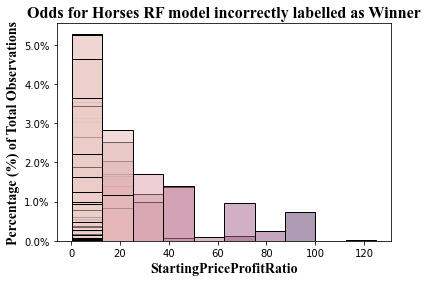

In [31]:
### Merge results from eval into one dataset

### rename 'Winnings' Col to avoid clash when merged
bookmaker_results.rename(columns={"Winnings":"BMWinnings"}, inplace=True)
rf_betting_results.rename(columns={"Winnings":"RFWinnings"}, inplace=True)

horses_test_merged = pd.merge(horses_test, bookmaker_results, on='HorseID', how='left')
horses_test_merged = pd.merge(horses_test_merged, rf_betting_results, on='HorseID', how='left')

# Which horses did the RF model get wrong?
rf_errors = horses_test_merged[horses_test_merged.RFWinnings==0]

# Compared to original distribution, we see far more long shots with mean at 24/1
plot_discrete_histogram(rf_errors,
                        'StartingPriceProfitRatio',
                        title='Odds for Horses RF model incorrectly labelled as Winner')

# Let's do a matrix plot to compare results between models


In [32]:
# I need an outer join! As we should keep both rows, even in the few cases where one model didn't provide results (54)
full_results = pd.merge(bookmaker_results,
                        rf_betting_results,
                        on='HorseID',
                        how='inner')

full_results['ModelComparison'] = np.where(
    ((full_results.BMWinnings > 0) & (full_results.RFWinnings > 0)), 'Both', np.where(
        (full_results.BMWinnings <= 0) & (full_results.RFWinnings > 0), 'RFOnly', np.where(
            (full_results.BMWinnings > 0) & (full_results.RFWinnings <= 0), 'BMOnly', 'Neither'
        )
    )
)
### Full Results Manual Review
display(full_results.head(6))

# Interestingly, BM got more right (Replace with confusion matrix)
display(full_results.groupby('ModelComparison').size())

# However, average winning higher for RF model
print('Average RF winning: {}\nAverage BM winnings: {}'.format(round(full_results.replace(0, np.NaN).RFWinnings.mean(),2),
                                                               round(full_results.replace(0, np.NaN).BMWinnings.mean(),2)))

HorseID  BMWinnings  RFWinnings ModelComparison
0  2913467         0.0         0.0         Neither
1  2903774         4.0         0.0          BMOnly
2  2903774         0.0         0.0         Neither
3  2980186         0.0         0.0         Neither
4  2980186         0.0         0.0         Neither
5  2980186         0.0         0.0         Neither

ModelComparison
BMOnly      436
Both        269
Neither    2929
RFOnly      321
dtype: int64

Average RF winning: 5.39
Average BM winnings: 3.99


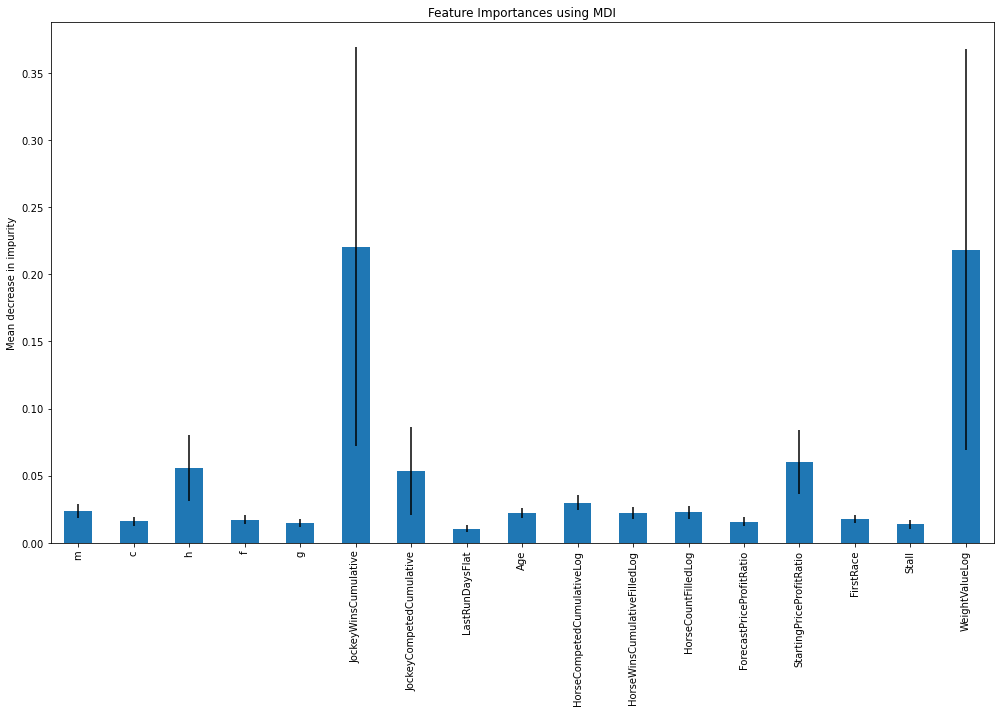

In [34]:
# Get the feature importance (weight) and the spread of feature importance across estimators.

# Additional features saved on RF by Gridsearch (optimisation). Find weights for 17 features used for training.
MODEL_FEATURES.reverse()
rf_feature_importance = pd.Series(best_rf_model_fitted.feature_importances_[0:17],
                                  index=MODEL_FEATURES)
std = np.std([tree.feature_importances_[0:17] for tree in best_rf_model_fitted.estimators_],
             axis=0)
fig, ax = plt.subplots(figsize=(14,10) )
rf_feature_importance.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature Importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

### Modelling Summary

##### Modelling Results
* The RandomForest proved to be the best model over the training set of 29455 observations (80%).
* The RandomForest was compared to a 'baseline' model using the remaining 7364 observations (20%).
* A person betting on all bookmaker favourites wins (the lowest winnings) 63.1p per £ invested.
* A person betting using the RF model's favourite (the highest predicted prob) would make 86.3 per £ invested.
* This means the RF model outperforms the baseline model by 23.2p (27%) per £
    * The 23.2p improvement provides evidence that ML modelling can improve bookmaker odds
    * However, the RF model still fails to 'beat the bookmaker' as it loses 13.7p per bet.
    * See Next Steps for possible approaches to improving the modelling completed in this notebook.

##### Model Analysis Results
* Model Analysis found that the RF model tended to pick horses with longer odds (non-favourites)
      * This resulted in fewer correct guesses overall but a higher reward for each correct guess and a larger mean return.
      * The most important features for RF modelling were Weight value and Jockey cumulative wins.
      * This helps RF model explainability given that these two features were identified as having a strong positive correlation with the label during statistical analysis.
      * StartingPriceProfitRatio (bookmaker odds) is another key feature.
      * Therefore, we might be able to interpret RF predictions as incorporating bookmaker info + new info.

##### Limitations
* Small sample period (nine months): there's no guarantee that the nine months sampled will reflect the future.
* Small sample period (nine months): smaller samples are at more risk of heteroskedasticity issues.
* Limited variation in types of observations.
    * flat races only (implied) - will models generalise to other race types?
* Lack of SME input on assumptions can mean results are not valid.
    * Plenty of areas of ambiguity are raised in section 3.
* Limitations in hyper-param tuning
    * DT max depth and max features limitations
    * RF number estimators are limited to 100. Improvements may come with using >100.
    * NN was not deep (3HL) and
* Issue with Keras backend mean NN was evaluated using accuracy, which may explain poor performance.

##### Next Steps
* improve the NN implementation (rever to old Keras) to eval using f1 or recall
* We should explore different structures of NN (compression, deep, autoencoder).
* Run with a much wider pool of parameters for all models by switching to cloud-distributed training.
* KNN (not enough ram)
* SMOTE and data generation (ram issues)
* Control for heteroskedasticity to make all models more generalisable.
* Incorporate other data sources (https://www.totalperformancedata.com/ etc.)